# FARSITE Demo

**Complete workflow for running FARSITE fire simulations with real data.**

## Steps:
1. Define fire location
2. Download LANDFIRE landscape data (5-10 min)
3. Fetch weather from WIFIRE Firemap
4. Generate landscape file (.lcp)
5. Run FARSITE simulation
6. Visualize results

## Requirements:
- TestFARSITE and lcpmake in src/ directory
- Valid email for LANDFIRE API
- Internet connection

## Setup

In [1]:
# Setup python/conda environment
!chmod +x install_packages.sh
!./install_packages.sh

In [2]:
import sys
from pathlib import Path
from datetime import datetime, timedelta

# Add src directory to path
DEMO_DIR = Path.cwd()
SRC_DIR = DEMO_DIR / "src"
sys.path.insert(0, str(SRC_DIR))

import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd

# Import from src/
from data_retrieval import download_landfire_data, fetch_weather, generate_lcp_from_rasters
from farsite import forward_pass_farsite, forward_pass_farsite_24h

print(f"✓ Demo directory: {DEMO_DIR}")
print(f"✓ Src directory: {SRC_DIR}")

✓ Demo directory: /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo
✓ Src directory: /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/src


## 1. Define Fire Location and Time Window (Example: Border 2 Fire)

In [3]:
# ========== USER INPUTS ==========

# Location
IGNITION_LAT = 34.302          # Fire latitude
IGNITION_LON = -118.997        # Fire longitude
RADIUS_MILES = 5               # Landscape download radius

# Time window for weather data
START_TIME = "2023-10-31T20:58:00"  # Start datetime (ISO format)
END_TIME = "2023-11-01T20:58:00"    # End datetime (24 hours later)

# Simulation duration
DURATION_HOURS = 6             # How long to simulate

# Email (required for LANDFIRE)
YOUR_EMAIL = "h7ahmed@ucsd.edu"  # REPLACE WITH YOUR EMAIL ADDRESS

# =================================

print(f"Fire location: ({IGNITION_LAT}, {IGNITION_LON})")
print(f"Download radius: {RADIUS_MILES} miles")
print(f"Weather window: {START_TIME} to {END_TIME}")
print(f"Simulation duration: {DURATION_HOURS} hours")

Fire location: (34.302, -118.997)
Download radius: 5 miles
Weather window: 2023-10-31T20:58:00 to 2023-11-01T20:58:00
Simulation duration: 6 hours


## 2. Download LANDFIRE Data

**This takes a couple minutes.**

In [4]:
landfire_dir = DEMO_DIR / "landfire_data"

# Download 8 landscape layers
rasters = download_landfire_data(
    center_lat=IGNITION_LAT,
    center_lon=IGNITION_LON,
    radius_miles=RADIUS_MILES,
    output_dir=landfire_dir,
    email=YOUR_EMAIL,
    verbose=True
)

Radius: 5 miles
Bounding box: [-119.0844, 34.2295, -118.9096, 34.3745]

Submitting LANDFIRE request...
✓ Job ID: 51e1c401-664f-4887-94da-de180ded1aa9
  Notification will be sent to h7ahmed@ucsd.edu

Waiting for LANDFIRE processing (takes a couple minutes)...
  [0s] pending
  [11s] executing
  [21s] succeeded

✓ Completed in 21s
Downloading...
Extracting...

Converting j62a9ae5bf2594f98a29abb2e9f006f94.tif to ASCII rasters...


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBD.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CBH.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CC.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250CH.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ 250FBFM40.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ASP2020.asc


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


  ✓ ELEV2020.asc
  ✓ SLPP2020.asc

✓ LANDFIRE data downloaded to /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/


Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
Warning 1: The definition of projected CRS EPSG:5070 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.


## 3. Fetch Weather Data

In [5]:
# Query WIFIRE Firemap for weather
weather = fetch_weather(
    lat=IGNITION_LAT,
    lon=IGNITION_LON,
    start_dt=START_TIME,
    end_dt=END_TIME,
    verbose=True
)

print(f"\nWeather for simulation:")
print(f"  Wind speed: {weather['windspeed']:.1f} mph")
print(f"  Wind direction: {weather['winddirection']:.0f}°")


Querying weather near (34.302, -118.997)
Time window: 2023-10-31T20:58:00 to 2023-11-01T20:58:00
✓ Station: Unknown
  Observations: 144
  Mean wind: 1.8 mph @ 92°

Weather for simulation:
  Wind speed: 1.8 mph
  Wind direction: 92°


## 4. Generate Landscape File (.lcp)

In [6]:
lcp_path = DEMO_DIR / "landscape.lcp"

print("Generating landscape file...\n")

generate_lcp_from_rasters(
    output_path=lcp_path,
    elevation_asc=rasters['elevation'],
    slope_asc=rasters['slope'],
    aspect_asc=rasters['aspect'],
    fuel_asc=rasters['fuel'],
    canopy_cover_asc=rasters['canopy_cover'],
    canopy_height_asc=rasters['canopy_height'],
    canopy_base_asc=rasters['canopy_base'],
    canopy_density_asc=rasters['canopy_density'],
    latitude=IGNITION_LAT,
    fuel_model="fb40",
    verbose=True
)

Generating landscape file...


Running lcpmake command:
/home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/src/lcpmake -latitude 34.302 -landscape /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landscape -elevation /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/ELEV2020.asc -slope /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/SLPP2020.asc -aspect /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/ASP2020.asc -fuel /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/250FBFM40.asc -cover /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/250CC.asc -height /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/250CH.asc -base /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/250CBH.asc -density /home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landfire_data/250CBD.asc -fb40

✓ Landscape file created: /home/jovyan/work/WIFIRE-Digital-Twinners/F

PosixPath('/home/jovyan/work/WIFIRE-Digital-Twinners/FARSITE_demo/landscape.lcp')

## 5. Define Ignition Perimeter

In [7]:
# Convert ignition point to EPSG:5070 (FARSITE projection)
ignition_point = Point(IGNITION_LON, IGNITION_LAT)
ignition_gdf = gpd.GeoDataFrame(geometry=[ignition_point], crs="EPSG:4326")
ignition_gdf = ignition_gdf.to_crs("EPSG:5070")

# Create 100m radius circle as initial fire
ignition_poly = ignition_gdf.geometry.iloc[0].buffer(100)

print(f"Ignition: 100m circle at ({IGNITION_LAT}, {IGNITION_LON})")
print(f"Initial area: {ignition_poly.area / 1e6:.4f} km²")

Ignition: 100m circle at (34.302, -118.997)
Initial area: 0.0314 km²


## 6. Run FARSITE Simulation
**This typically takes 5-10 minutes, depending on the timestep length/quantity.**

In [8]:
weather['windspeed']

1.7697916666666667

In [9]:
# Define initial parameters
sim_start = datetime.fromisoformat(START_TIME.replace('T', ' '))
farsite_params = {
    'windspeed': weather['windspeed'],
    'winddirection': weather['winddirection'],
    'dt': pd.Timedelta(minutes=30)
}


# Run FARSITE
result = forward_pass_farsite(
    poly=ignition_poly,
    lcppath=str(lcp_path),
    params=farsite_params,
    start_time=sim_start,
    dist_res=150,
    perim_res=150,
)

## 7. Visualize Results


SIMULATION RESULTS
Duration: 6 hours
Final area: 0.00 km² (0 acres)
Growth: -0.03 km²
Avg spread rate: -0.01 km²/hour


/tmp/ipykernel_4854/1812645681.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper left')


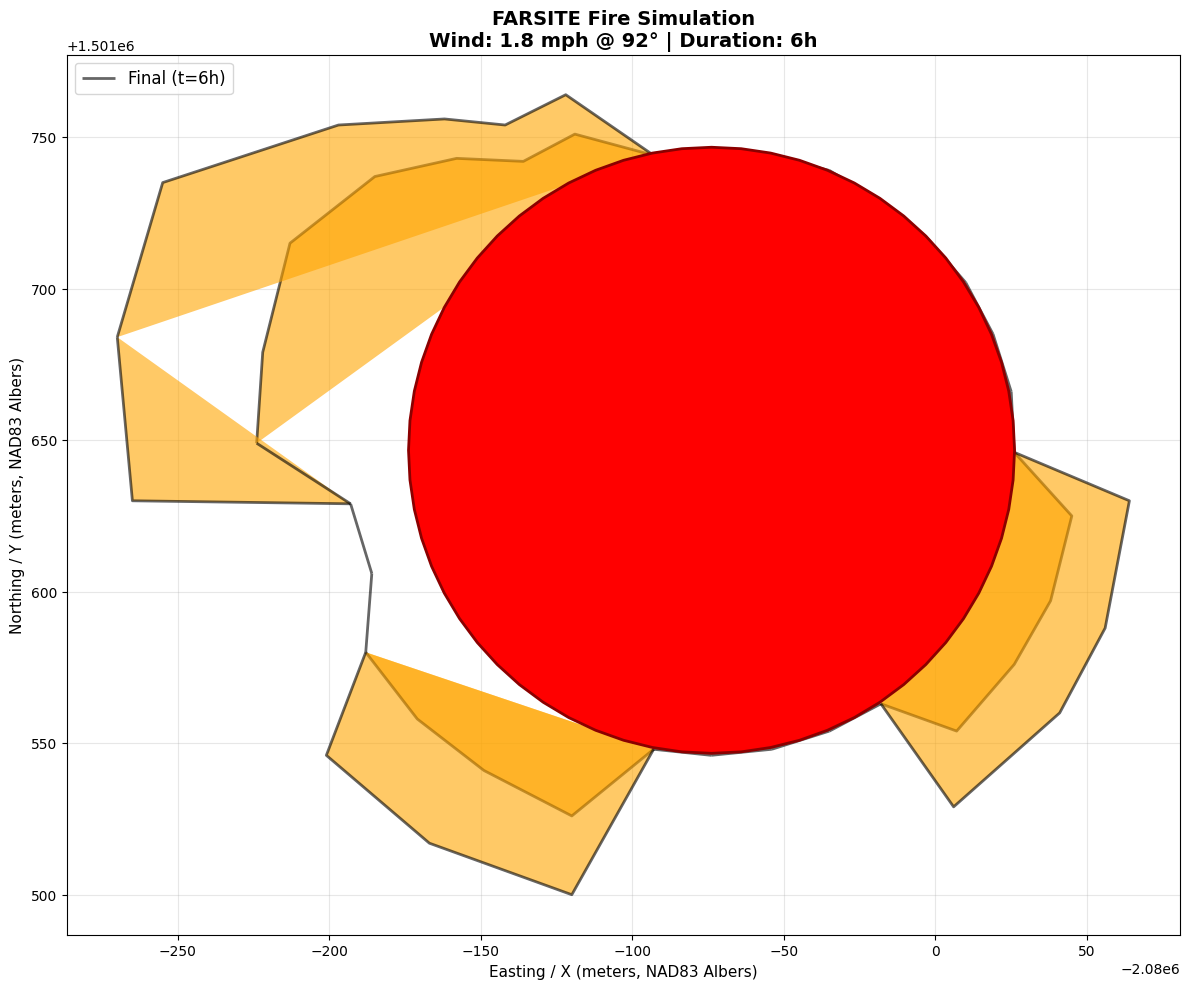

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot ignition
gpd.GeoDataFrame(geometry=[ignition_poly], crs="EPSG:5070").plot(
    ax=ax, color='red', edgecolor='darkred', linewidth=2, 
    label='Ignition (t=0)', zorder=3
)

# Plot result
if result:
    gpd.GeoDataFrame(geometry=[result], crs="EPSG:5070").plot(
        ax=ax, facecolor='orange', edgecolor='black',
        alpha=0.6, linewidth=2, 
        label=f'Final (t={DURATION_HOURS}h)', zorder=2
    )
    
    # Calculate statistics
    area_km2 = result.area / 1e6
    area_acres = area_km2 * 247.105
    growth_km2 = (result.area - ignition_poly.area) / 1e6
    
    print(f"\n{'='*60}")
    print("SIMULATION RESULTS")
    print(f"{'='*60}")
    print(f"Duration: {DURATION_HOURS} hours")
    print(f"Final area: {area_km2:.2f} km² ({area_acres:.0f} acres)")
    print(f"Growth: {growth_km2:.2f} km²")
    print(f"Avg spread rate: {growth_km2 / DURATION_HOURS:.2f} km²/hour")
    print(f"{'='*60}")
else:
    print("⚠ No result - simulation may have failed")

ax.legend(fontsize=12, loc='upper left')
ax.set_xlabel('Easting / X (meters, NAD83 Albers)', fontsize=11)
ax.set_ylabel('Northing / Y (meters, NAD83 Albers)', fontsize=11)
ax.set_title(
    f'FARSITE Fire Simulation\n'
    f'Wind: {weather["windspeed"]:.1f} mph @ {weather["winddirection"]:.0f}° | '
    f'Duration: {DURATION_HOURS}h',
    fontsize=14, fontweight='bold'
)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

**Files created:**
- `landfire_data/*.asc` - Downloaded LANDFIRE landscape layers
- `landscape.lcp` - FARSITE landscape file

**Next steps:**
- Try different wind speeds/directions
- Extend simulation duration
- Compare with observed fire perimeters
- Run parameter sensitivity analysis

**Modify these variables to experiment:**
```python
IGNITION_LAT/LON      # Different fire locations
RADIUS_MILES          # Larger/smaller landscape area
START_TIME/END_TIME   # Different weather periods
DURATION_HOURS        # Longer/shorter simulations
```